In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from data_generation import franke_function
from data_generation import generate_data_Franke
from feedforward_nn import NeuralNetwork
from gradient_descent import GradientDescent
from regression_tools import accuracy
from regression_tools import create_X_polynomial
from regression_tools import MSE
from regression_tools import MSE_vec

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
"""
# Generate Franke function data
x, y, z, z_true = generate_data_Franke(1000, 0.1, 1)
X = np.c_[x, y]



# Split data into training and test sets
X_TR, X_test, z_TR, z_test = train_test_split(X, z, test_size=0.2)
X_train, X_val, z_train, z_val = train_test_split(X_TR, z_TR, test_size=0.2)
n = X_train.shape[1]

np.save("data/franke/X_TR.npy", X_TR)
np.save("data/franke/X_train.npy", X_train)
np.save("data/franke/X_val.npy", X_val)
np.save("data/franke/X_test.npy", X_test)
np.save("data/franke/z_TR.npy", z_TR)
np.save("data/franke/z_train.npy", z_train)
np.save("data/franke/z_val.npy", z_val)
np.save("data/franke/z_test.npy", z_test)
"""

X_TR = np.load("data/franke/X_TR.npy")
X_train = np.load("data/franke/X_train.npy")
X_val = np.load("data/franke/X_val.npy")
X_test = np.load("data/franke/X_test.npy")
z_TR = np.load("data/franke/z_TR.npy")
z_train = np.load("data/franke/z_train.npy")
z_val = np.load("data/franke/z_val.npy")
z_test = np.load("data/franke/z_test.npy")
n = X_train.shape[1]



In [51]:

# Use StandardScaler to scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)
X_TR = scaler.transform(X_TR)


z_train = scaler.fit_transform(z_train.reshape(-1, 1)).ravel()
z_val = scaler.transform(z_val.reshape(-1, 1)).ravel()
z_test = scaler.transform(z_test.reshape(-1, 1)).ravel()
z_TR = scaler.transform(z_TR.reshape(-1, 1)).ravel()
print(n)



2


In [5]:
def optimal_reg_neural_network(X_train, 
                               z_train, 
                               X_val, 
                               z_val, 
                               layers, 
                               regularizationrange, 
                               momentum=0.9,
                               avg_num = 10,
                               optmode="normal", 
                               max_iter=200, 
                               eta=0.01,
                               activation="sigmoid",
                               output_activation="linear",
                               ):
    """Returns the optimal regularization parameter for a neural network with the given parameters, taking the average over avg_num runs."""
    pred_cost_val = []
    cost_val = []
    for reg in regularizationrange:
        # Average over avg_num runs
        pred_cost = 0
        cost = 0
        for _ in range(avg_num):
            nn = NeuralNetwork(layers, activation=activation, output_activation=output_activation, regularization=reg, cost_function="mse")
            w0 = nn.wb()
            batch_size = 32
            store_extra = True

            gd = GradientDescent(batch_size=batch_size, momentum_param=momentum, store_extra=store_extra, mode=optmode)
            w = gd.train(X_train, w0, z_train, nn, eta, max_iter)
            cost += gd.costs[-1]
            z_pred = nn.predict(X_val, w)
            pred_cost += MSE(z_val, z_pred.flatten())
        pred_cost /= avg_num
        cost /= avg_num
        pred_cost_val.append(pred_cost)
        cost_val.append(cost)

    # Return best regularization parameter, corresponding accuracy and accuracy_val
    return regularizationrange[np.argmin(cost_val)], np.min(cost_val), pred_cost_val, cost_val
    

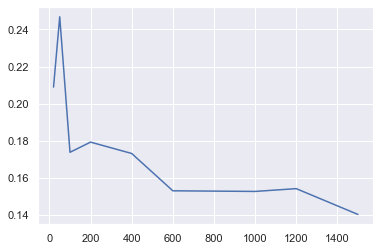

In [129]:
"""
nn = NeuralNetwork([n, 20, 10, 1], activation="leaky_relu", output_activation="linear", regularization=0.0, cost_function="cross_entropy")
w0 = nn.wb()
batch_size = 16
store_extra = True

gd = GradientDescent(batch_size=batch_size, momentum_param=0.9, store_extra=store_extra, mode="normal")
w = gd.train(X_train, w0, z_train, nn, 0.005, 2000)

costs = gd.costs
epochs = np.linspace(0, len(costs), len(costs))
MSE_epochs = MSE_vec(z_val, nn.predict(X_val, gd.weights))
sns.set_theme()
plt.plot(MSE_epochs)
plt.xlabel("Epoch")
plt.ylabel("Cost")
plt.title("NN cost as a function of epochs")
plt.savefig("plots/franke_nn/nn_cost_epochs.png")
plt.show()
"""

MSE_arr = []
epochs = [20, 50, 100, 200, 400, 600, 1000, 1200, 1500]
for epoch in epochs:
    nn = NeuralNetwork([n, 10, 10, 1], activation="leaky_relu", output_activation="linear", regularization=0.0001, cost_function="mse")
    w0 = nn.wb()
    batch_size = 32
    store_extra = True

    gd = GradientDescent(batch_size=batch_size, momentum_param=0.9, store_extra=store_extra, mode="normal")
    w = gd.train(X_train, w0, z_train, nn, 0.0005, epoch)
    wb = nn.wb()
    z_pred = nn.predict(X_val, wb)
    MSE_val = MSE(z_val, z_pred.flatten())
    # print(f"Epochs: {epoch}, MSE: {MSE_val}, Max in z_pred: {np.max(z_pred)}, Min in z_pred: {np.min(z_pred)}")
    MSE_arr.append(MSE_val)

sns.set_theme()
plt.plot(epochs, MSE_arr)
plt.show()



In [130]:
# Perform grid search on regularization for each activation function
activations = ["linear", "sigmoid", "relu", "leaky_relu"]
best_lam = []
best_cost = []
predcost_val = []
cost_val = []
avg_num = 1
max_iter = 1000
eta = 0.0005
layers = [n, 10, 10, 1]
for activation in activations:
    print(f"Activation: {activation}")
    lambdas = np.logspace(-15, 1, 15)
    best_lam_act, best_cost_act, pred_cost_val_act, cost_val_act = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layers, lambdas, optmode="normal", avg_num=avg_num, max_iter=max_iter, eta=eta, activation=activation)
    best_lam.append(best_lam_act)
    best_cost.append(best_cost_act)
    predcost_val.append(pred_cost_val_act)
    cost_val.append(cost_val_act)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNfranke_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Activation: {activation}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={eta}, layers={layers}\n")
        f.write(f"Best lambda: {best_lam_act}\n")
        f.write(f"Best cost: {best_cost_act}\n")
        f.write(f"Pred cost val: {pred_cost_val_act}\n")
        f.write(f"Cost val: {cost_val_act}\n")
        f.write(f"--------------------------------------------------------\n")
        


Activation: linear
Activation: sigmoid
Activation: relu
Activation: leaky_relu


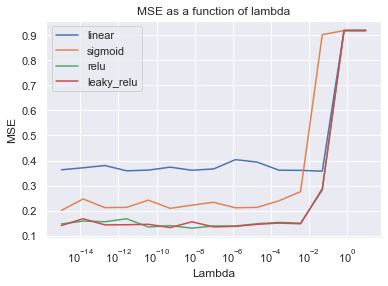

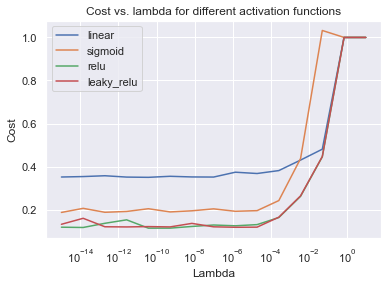

[0.14021746434594298, 0.16731896392359605, 0.14274364551923804, 0.14327320968175433, 0.14515965456935664, 0.13187502378254662, 0.1550260688481419, 0.1347345415062175, 0.1368205644991778, 0.14497208939820966, 0.1501064590541245, 0.1470938137235169, 0.2875061156390605, 0.919615171474393, 0.9195783028619366]


In [131]:
# Plot predictive cost as a function of regularization parameter for each activation function
sns.set_theme()
for i, activation in enumerate(activations):
    plt.semilogx(lambdas, predcost_val[i], label=activation)
plt.xlabel("Lambda")
plt.ylabel("MSE")
plt.title("MSE as a function of lambda")
plt.legend()
plt.savefig("plots/franke_nn/nn_predcost_lambda.png")
plt.show()


# Plot cost vs. regularization parameter for each activation function
for i in range(len(activations)):
    plt.semilogx(lambdas, cost_val[i], label=activations[i])
    plt.xlabel("Lambda")
    plt.ylabel("Cost")
    plt.title("Cost vs. lambda for different activation functions")
    plt.legend()
plt.savefig("plots/franke_nn/cost_lambda.png")
plt.show()

print(predcost_val[3])


We choose Leaky ReLu as this stays more stable over the regularization range

In [24]:

# Grid search on regularization parameter for each mode - low resolution, as we only want to find the best mode
modes = ["normal", "adagrad", "rmsprop", "adam"]
best_lam = []
best_cost = []
predcost_val = []
cost_val = []
avg_num = 1
max_iter = 1000
eta = 0.0005
layers = [n, 10, 10, 1]
actfunc = "leaky_relu"
for mode in modes:
    print(f"Mode: {mode}")
    lambdas = np.logspace(-15, 1, 15)
    best_lam_mode, best_cost_mode, accuracy_val_mode, cost_val_mode = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layers, lambdas, optmode=mode, avg_num=avg_num, max_iter=max_iter, eta=eta, activation=actfunc)
    best_lam.append(best_lam_mode)
    best_cost.append(best_cost_mode)
    predcost_val.append(accuracy_val_mode)
    cost_val.append(cost_val_mode)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNfranke_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Iterating over modes\n")
        f.write(f"Mode: {mode}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={eta}, layers={layers}, activation={actfunc}\n")
        f.write(f"Best lambda: {best_lam_mode}\n")
        f.write(f"Best accuracy: {best_cost_mode}\n")
        f.write(f"Accuracy val: {accuracy_val_mode}\n")
        f.write(f"Cost val: {cost_val_mode}\n")
        f.write(f"--------------------------------------------------------\n")


Mode: normal
Mode: adagrad
Mode: rmsprop
Mode: adam


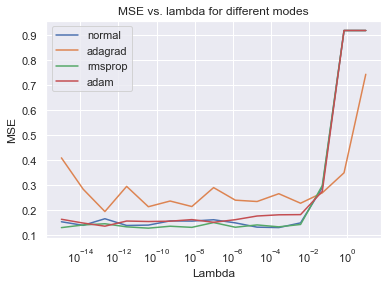

Mode	Best lambda	MSE
normal	2.68e-12	0.12
adagrad	1.93e-13	0.18
rmsprop	1.93e-13	0.11
adam	1.93e-13	0.12


In [25]:
# Plot accuracy vs. regularization parameter for each mode
for i in range(len(modes)):
    plt.semilogx(lambdas, predcost_val[i], label=modes[i])
    plt.xlabel("Lambda")
    plt.ylabel("MSE")
    plt.title("MSE vs. lambda for different modes")
    plt.legend()
# Save figure as plots/accuracy_lambda_mode.png
plt.savefig("plots/franke_nn/accuracy_lambda_mode_with_title.png")
plt.show()

# Print best regularization parameter for each mode as a table
print("Mode\tBest lambda\tMSE")
for i in range(len(modes)):
    print(f"{modes[i]}\t{best_lam[i]:.2e}\t{best_cost[i]:.2f}")

We choose AdaGrad as this, together with constant learning rate, stays the most stable across the regularization range.

In [15]:
# Perform grid search on learning rate and regularization parameter
lrrange = np.logspace(-6, 0, 10)
best_lam = []
best_cost = []
accuracy_mat = []
best_lr = []
cost_val = []
avg_num = 1
max_iter = 1000
layers = [n, 10, 10, 1]
actfunc = "leaky_relu"
mode = "adagrad"
progress = 0
print(f"Progress: {100 * progress / len(lrrange):.2f}%", end="\r")
for lr in lrrange:
    lambdas = np.logspace(-15, -1, 10)
    best_lam_lr, best_acc_lr, accuracy_val_lr, cost_val_lr = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layers, lambdas, optmode=mode, avg_num=avg_num, max_iter=max_iter, eta=lr, activation=actfunc)
    accuracy_mat.append(accuracy_val_lr)
    best_lam.append(best_lam_lr)
    best_cost.append(best_acc_lr)
    best_lr.append(lr)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNfranke_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Iterating over learning rates\n")
        f.write(f"Learning rate: {lr}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={lr}, layers={layers}, activation={actfunc}\n")
        f.write(f"Best lambda: {best_lam_lr}\n")
        f.write(f"Best accuracy: {best_acc_lr}\n")
        f.write(f"Predictive cost val: {accuracy_val_lr}\n")
        f.write(f"Cost val: {cost_val_lr}\n")
        f.write(f"--------------------------------------------------------\n")
    progress += 1/len(lrrange)
    print(f"Progress: {progress:.2%}", end="\r")



Best cost: 0.12437564
Best learning rate: 1.00000000e-02
Best lambda: 5.99e-08


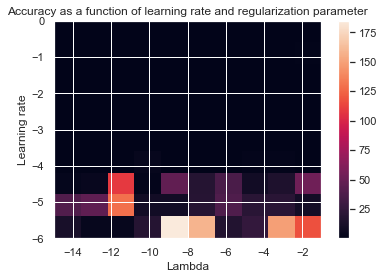

In [16]:
# Make heatmap plot of accuracy vs. learning rate and regularization parameter
accuracy_mat = np.array(accuracy_mat)
X, Y = np.meshgrid(lambdas, lrrange)
fig = plt.figure()
plt.imshow(accuracy_mat, extent=[np.log10(lambdas[0]), np.log10(lambdas[-1]), np.log10(lrrange[0]), np.log10(lrrange[-1])], origin="lower", aspect="auto")
plt.colorbar()
plt.xlabel("Lambda")
plt.ylabel("Learning rate")
plt.title("Accuracy as a function of learning rate and regularization parameter")
# Save figure as plots/accuracy_lambda_lr.png
plt.savefig("plots/accuracy_lambda_lr.png")

# Print best accuracy and corresponding learning rate and regularization parameter
best_acc = 1000
best_lr = 1000
best_lam = 1000
for i in range(len(lrrange)):
    for j in range(len(lambdas)):
        if accuracy_mat[i, j] < best_acc:
            best_acc = accuracy_mat[i, j]
            best_lr = lrrange[i]
            best_lam = lambdas[j]
print(f"Best cost: {best_acc:.8f}")
print(f"Best learning rate: {best_lr:.8e}")
print(f"Best lambda: {best_lam:.2e}")


In [19]:
nn_structures = [
    [n, 10, 10, 10, 10, 10, 1],
    [n, 10, 10, 1],
    [n, 4, 4, 4, 4, 4, 1],
    [n, 4, 4, 1]
]


best_lam = []
predcost_val = []
cost_val = []
avg_num = 1
max_iter = 1000
actfunc = "leaky_relu"
mode = "adagrad"
lr = 10**(-2)
progress = 0
print(f"Progress: {100 * progress / len(lrrange):.2f}%", end="\r")
for layer in nn_structures:
    lambdas = np.logspace(-15, -1, 10)
    best_lam_nn, best_acc_nn, accuracy_val_nn, cost_val_nn = optimal_reg_neural_network(X_train, z_train, X_val, z_val, layer, lambdas, optmode=mode, avg_num=avg_num, max_iter=max_iter, eta=lr, activation=actfunc)
    predcost_val.append(accuracy_val_nn)
    best_lam.append(best_lam_nn)
    best_cost.append(best_acc_nn)
    # Save results to Results/NNcancer_gridsearch.txt
    with open("Results/NNfranke_gridsearch.txt", "a") as f:
        f.write(f"\n\n")
        f.write(f"Iterating over learning rates\n")
        f.write(f"Learning rate: {lr}\n")
        f.write(f"Lambdas: {lambdas}\n")
        f.write(f"Parameters: avg_num={avg_num}, max_iter={max_iter}, eta={lr}, layers={layers}, activation={actfunc}\n")
        f.write(f"Best lambda: {best_lam_nn}\n")
        f.write(f"Best accuracy: {best_acc_nn}\n")
        f.write(f"Predictive cost val: {accuracy_val_nn}\n")
        f.write(f"Cost val: {cost_val_nn}\n")
        f.write(f"--------------------------------------------------------\n")
    progress += 1/len(nn_structures)
    print(f"Progress: {progress:.2%}", end="\r")


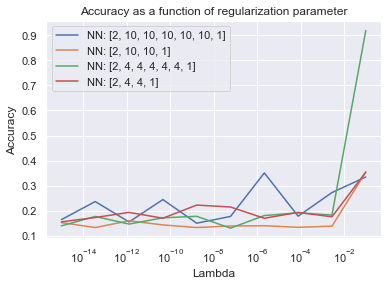

Best accuracy for NN: [2, 10, 10, 10, 10, 10, 1]: 3.0930
Best lambda for NN: [2, 10, 10, 10, 10, 10, 1]: 1.6681e-09
Best accuracy for NN: [2, 10, 10, 1]: 10.2938
Best lambda for NN: [2, 10, 10, 1]: 3.5938e-14
Best accuracy for NN: [2, 4, 4, 4, 4, 4, 1]: 2.5642
Best lambda for NN: [2, 4, 4, 4, 4, 4, 1]: 5.9948e-08
Best accuracy for NN: [2, 4, 4, 1]: 0.3245
Best lambda for NN: [2, 4, 4, 1]: 1.0000e-15
[1.00000000e-15 3.59381366e-14 1.29154967e-12 4.64158883e-11
 1.66810054e-09 5.99484250e-08 2.15443469e-06 7.74263683e-05
 2.78255940e-03 1.00000000e-01]


In [20]:
# Plot accuracy as a function of regularization parameter for each neural network structure
sns.set_theme()
for i in range(len(nn_structures)):
    plt.plot(lambdas, predcost_val[i], label=f"NN: {nn_structures[i]}")
plt.semilogx()
plt.xlabel("Lambda")
plt.ylabel("Accuracy")
plt.title("Accuracy as a function of regularization parameter")
plt.legend()
# Save figure as plots/accuracy_lambda_nn.png
plt.savefig("plots/franke_nn/accuracy_lambda_nn.png")
plt.show()

# Print best accuracy and corresponding regularization parameter for each neural network structure
for i in range(len(nn_structures)):
    print(f"Best accuracy for NN: {nn_structures[i]}: {best_cost[i]:.4f}")
    print(f"Best lambda for NN: {nn_structures[i]}: {lambdas[np.argmin(predcost_val[i])]:.4e}")

print(lambdas)


In [26]:
# Find the average accuracy for the best model on the test set
best_nn = [n, 10, 10, 1]
lam = lambdas[np.argmin(predcost_val[i])]
max_iter = 1000
actfunc = "leaky_relu"
mode = "rmsprop"
eta = 6 * 10**(-5)
avg_num = 1
mserr = 0
for i in range(avg_num):
    nn = NeuralNetwork(best_nn, activation=actfunc, output_activation="linear", regularization=lam, cost_function="mse")
    w0 = nn.wb()
    batch_size = 32
    store_extra = True

    gd = GradientDescent(batch_size=batch_size, momentum_param=0.9, store_extra=store_extra, mode=mode)
    w = gd.train(X_TR, w0, z_TR, nn, eta, max_iter)
    z_pred = nn.predict(X_test, w)
    mserr += MSE(z_test, z_pred.flatten())
mserr /= avg_num
print(f"Average MSE on test set: {mserr:.4f}")

Average MSE on test set: 0.1482


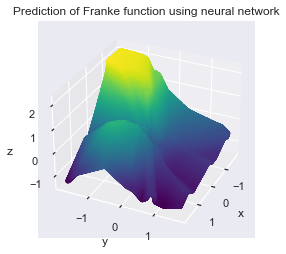

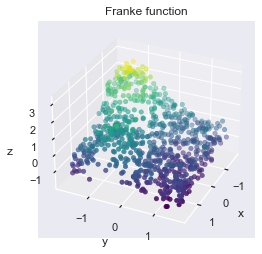

In [68]:
# Create 3d plot of prediction on x, y in [0, 1]
"""
print(f"Predicted [0.5, 0.5]: {nn.predict([0.5, 0.5], w).flatten()}")
print(f"True [0.5, 0.5]: {franke_function(0.5, 0.5)}")



def plot_3d(X, Y, Z, title="", filename=""):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap="viridis", linewidth=0, antialiased=False)
    # Rotate the axes and update
    ax.view_init(30, 25)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title(title)
    if filename:
        plt.savefig(filename)
    plt.show()

# Get first element in each element in XY
X = np.array([x[0] for x in X_TR])
Y = np.array([x[1] for x in X_TR])
X_new, Y_new = np.meshgrid(X, Y)
Z = (nn.predict(np.c_[X_new.ravel(), Y_new.ravel()], w).flatten()).reshape(X_new.shape)
plot_3d(X_new, Y_new, Z, title="Prediction of Franke function")

print(nn.predict(np.c_[X.ravel(), Y.ravel()], w).flatten())
"""


X = np.array([x[0] for x in X_TR])
Y = np.array([x[1] for x in X_TR])
X_new, Y_new = np.meshgrid(X, Y)
Z = (nn.predict(np.c_[X_new.ravel(), Y_new.ravel()], w).flatten()).reshape(X_new.shape)

# Make 3d scatterplot with rainbow colors of data
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_new, Y_new, Z, c=Z, cmap="viridis", linewidth=0.5)
# Rotate the axes and update
ax.view_init(30, 25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Prediction of Franke function using neural network")
plt.savefig("plots/franke_nn/prediction_nn.png")
plt.show()


# Plot X_TR, Y_TR, z_TR as a 3d scatterplot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X, Y, z_TR, c=z_TR, cmap="viridis", linewidth=0.5)
# Rotate the axes and update
ax.view_init(30, 25)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
plt.title("Franke function")
plt.savefig("plots/franke_nn/franke_function_real.png")
plt.show()

